In [2]:
import wildqat as wq
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
aaa = wq.opt()

# データ読み込み

In [55]:
#座標
positions = np.array((
    (24050.0000, 123783),
    (24216.6667, 123933),
    (24233.3333, 123950),
    (24233.3333, 124016),
    (24250.0000, 123866),
    (24300.0000, 123683),
    (24316.6667, 123900),
    (24316.6667, 124083),
    (24333.3333, 123733),
))

positions = np.array((
    (0, 0),
    (2, 0),
    (2, 4),
    (0, 3),
))

#距離の計算
def dist(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(((a - b)**2).sum())

#町の数
N = len(positions)
#定数A
A = 2000

#距離行列Dを計算
D = np.empty((N, N), dtype = np.float64)
for i in range(N):
    for j in range(N):
        D[i, j] = dist(positions[i], positions[j])

# 行列Jの計算

In [41]:
#クロネッカーデルタを定義
def delta(i, j):
    if(i == j):
        return 1
    else:
        return 0

#行列Jを計算
J = np.empty((N, N, N, N), dtype = np.float64)
for a in range(N):
    for t1 in range(N):
        for b in range(N):
            for t2 in range(N):
                J[a, t1, b, t2] =    delta((t1+1)%N, t2) * D[a, b] \
                                    + A * delta(t1, t2) + A * delta(a, b)- 4 * A * delta(a, b) * delta(t1, t2) 
#定数項の計算
C = 2 * A * N

# QUBO行列Qを計算

In [42]:
#Qの計算
Q = np.zeros((N*N,N*N), dtype = np.float64)
x = 0
for a in range(N):
    for t1 in range(N):
        y = 0
        for b in range(N):
            for t2 in range(N):
                if x<=y:
                    Q[x,y] = int(J[a,t1,b,t2])
                else:
                    Q[y,x] += int(J[a,t1,b,t2])
                y = y + 1
        x = x + 1
        
# 初めは0番目のポイント
Q [0,0] -= 10*A
#print(Q)

In [43]:
def cast_result(r):
    # 結果成型
    result = np.empty((N, N), dtype = np.int)
    i = 0
    for x in range(N):
        for y in range(N):
            if(r[i] == 1):
                result[x, y] = 1
            else:
                result[x, y] = 0
            i += 1
    return result
# 結果のチェック
def check_result(result):
    ch = True
    for i in range(N):
        if list(result[i]).count(1)!=1:
            ch = False
        if list(result[:,i]).count(1)!=1:
            ch = False
    return ch

def cal_len(result):
    #距離を計算する
    length = 0
    for t in range(N):
        for a in range(N):
            for b in range(N):
                if(result[a,t] == 1 and result[b,(t+1)%N] == 1):
                    length += D[a,b]
    return length

# 最適化計算

In [44]:
aaa.qubo=Q
min =100000000
r2 = []
for i in range(5):
    start = time.time()
    arrangement = aaa.sa()
    elapsed_time = time.time() - start
    print ("SA_time:{0}".format(elapsed_time) + "[sec]")
    #arrangement = arrangement[0]
    result = cast_result(arrangement)
    if check_result(result):
        ll = cal_len(result)
        print(ll)
        if ll<min:
            min = ll
            r2 = result
print("min=",ll)

SA_time:1.8864779472351074[sec]
12.0
SA_time:1.8812470436096191[sec]
12.0
SA_time:2.154350996017456[sec]
12.94427190999916
SA_time:2.0179479122161865[sec]
12.0
SA_time:1.8574540615081787[sec]
12.0
SA_time:2.0150249004364014[sec]
12.94427190999916
SA_time:1.9039061069488525[sec]
12.0
SA_time:2.0323801040649414[sec]
12.94427190999916
SA_time:1.8693499565124512[sec]
12.94427190999916
SA_time:1.930345058441162[sec]
12.94427190999916
min= 12.94427190999916


In [45]:
print(r2)

[[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]


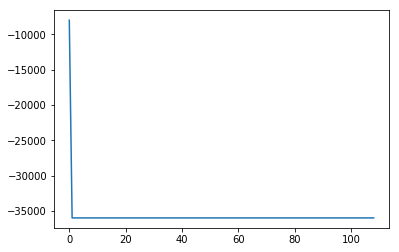

In [46]:
aaa.plot()

Simulated Annealing
12.0


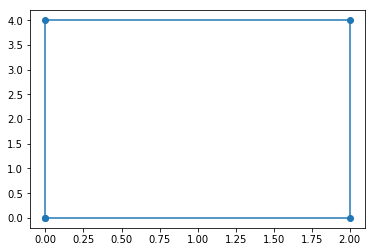

In [48]:
def plot_route(state, positions):
    route = [positions[np.argmax(row)] for row in state]
    route.append(route[0])
    route = np.array(route)
    
    d = 0
    for i in range(1, len(route)):
        d += dist(route[i - 1], route[i])
    print(d)
    plt.plot(route[:, 0], route[:, 1], '-o')
print('Simulated Annealing')
plot_route(r2, positions)
plt.show()

# Oceanで解く

ExactSolver：厳密解を求める

In [49]:
import dwave_networkx as dnx
import networkx as nx
from dimod import *
from dwave_qbsolv import QBSolv
from dwave.system import DWaveSampler, LazyFixedEmbeddingComposite
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite
my_dwave_token = "DEV-df04bbde850ca9170bb81627bc32675b76d18f10"
dictQ = {(i, j): line for i, row in enumerate(Q) for j, line in enumerate(row) if i <= j}
b = dimod.BinaryQuadraticModel.from_qubo(dictQ)
start = time.time()
#r = dimod.ExactSolver().sample(b)
elapsed_time = time.time() - start
#print ("ES_time:{0}".format(elapsed_time) + "[sec]")
start = time.time()
r = dimod.SimulatedAnnealingSampler().sample(b)
elapsed_time = time.time() - start
print ("SA_time:{0}".format(elapsed_time) + "[sec]")

#response = QBSolv().sample_qubo(dictQ, solver = sampler, solver_limit=60)
result = np.empty((N, N), dtype = np.int)
i = 0
s = r.first.sample
for i in range(len(s)):
    j = int(i/N)
    k = i%N
    result[j,k]=s[i]
print(result)
print(cal_len(result))

SA_time:2.0237510204315186[sec]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
12.94427190999916


# DwaveSampler

In [54]:
start = time.time()
sampler = EmbeddingComposite(DWaveSampler(token=my_dwave_token))
r = QBSolv().sample_qubo(dictQ, solver = sampler, solver_limit=60)
r = EmbeddingComposite(DWaveSampler(token=my_dwave_token)).sample_qubo(dictQ, num_reads=1000)
elapsed_time = time.time() - start
print ("DW_time:{0}".format(elapsed_time) + "[sec]")
print("Total_real_time ", r.info["timing"]["total_real_time"], " μs")
result = np.empty((N, N), dtype = np.int)
i = 0
print(r)
s = r.first.sample
for i in range(len(s)):
    j = int(i/N)
    k = i%N
    result[j,k]=s[i]
print(result)
if check_result(result):
    ll = cal_len(result)
    print(ll)

DW_time:3.6619620323181152[sec]
Total_real_time  324783  μs
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15   energy num_oc. ...
177  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0      10 ...
181  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       4 ...
186  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       4 ...
191  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       1 ...
195  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       1 ...
200  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       1 ...
202  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       1 ...
207  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       1 ...
208  1  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0 -35988.0       1 ...
185  1  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 -31994.0       1 ...
193  1  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0 -31994.0       1 ...
1    1  0  0  0  0  0  1  0  0  1  0  0  0  0  1  0 -31990.0    

# dnxのtraveling_salesman関数
EmbeddingCompositeがバグってる？？？

/Users/moriyama/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


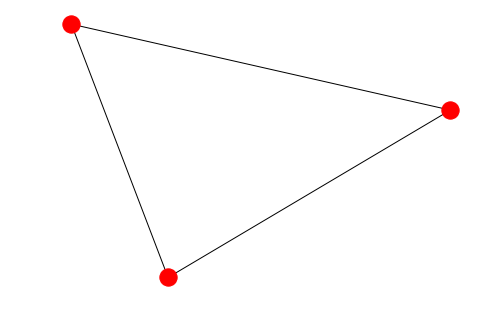

In [39]:
import dwave_networkx as dnx
import dimod
from dwave_qbsolv import QBSolv
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
my_dwave_token = "DEV-df04bbde850ca9170bb81627bc32675b76d18f10"
G = nx.complete_graph(3)
G.add_weighted_edges_from({(0, 1, 2), (0, 2, 3), (1, 2, 1)})
dictQ = {(i, j): line for i, row in enumerate(Q) for j, line in enumerate(row) if i <= j}
sampler = EmbeddingComposite(DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi', token=my_dwave_token, solver='DW_2000Q_5'))
#sampler = dimod.ExactSolver()
'''sampler = FixedEmbeddingComposite(DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi', token=my_dwave_token, solver='DW_2000Q_5'), 
                                  {(0,0): [0, 4], (0,1): [1, 5], (0,2): [2, 6],
                                   (1,0): [3, 7], (1,1): [8, 12], (1,2): [9, 13],
                                   (2,0): [10, 14], (2,1): [11, 15], (2,2): [16, 20]})'''
#response = QBSolv().sample_qubo(dictQ, solver = sampler, solver_limit=60)
ans1 = dnx.traveling_salesman(G, dimod.ExactSolver())
Q = dnx.algorithms.traveling_salesman_qubo(G)
h, J, off = dimod.BinaryQuadraticModel.from_qubo(Q).to_ising()
ans2 = sampler.sample_qubo(Q, num_reads=100)
ans2 = ans2.first
#ans2 = dnx.traveling_salesman(G, sampler)
nx.draw(G)
plt.show()

In [38]:
print(ans1,"\n",ans2.sample)#record.sample.reshape(3,3))

[1, 2, 0] 
 {(0, 1): 0, (1, 2): 0, (0, 0): 0, (2, 0): 0, (1, 0): 1, (2, 2): 0, (0, 2): 0, (2, 1): 0, (1, 1): 1}


In [14]:
Q = {(0, 0):-5,
     (0, 1): 4,
     (1, 1): -8
    }
b = BinaryQuadraticModel.from_qubo(Q, 9.0)
print(b)
sampler = EmbeddingComposite(DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi', token=my_dwave_token, solver='DW_2000Q_5', num_reads=10))
#sampler = FixedEmbeddingComposite(DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi', token=my_dwave_token, solver='DW_2000Q_5'), {0: [0,4], 1: [1,5]})
ans2 = sampler.sample_qubo(Q)
print(ans2.record.sample)

BinaryQuadraticModel({0: -5, 1: -8}, {(0, 1): 4}, 9.0, Vartype.BINARY)
[[1 1]]
